# Market share analysis

## Author: Snigdhayan Mahanta
Consider a hypothetical market that has 5 brands for a particular product. Let us suppose that the attractiveness of a brand is proportional to its market share. Our task is to ascertain the market share of each of these brands after 10 years. Assume that the market size remains constant for simplicity. Let me summarize my approach below:
1. I created an artificial market of a reasonable size, where the total number of products is distributed randomly among the 5 brands.
1. I drew a random sample of a small size and estimated the current market share based on that.
2. I used the `categorical distribution` from `tensorflow probability` to calculate iteratively the market share after 10 years.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

In [2]:
# Define the market parameters
market_size = int(1e6)
brands = np.array([i+1 for i in range(5)], dtype='int32') # enumeration of brands

array = np.random.choice(range(10,100), len(brands))
market_share = array/sum(array) # fractional distribution

# The market is defined by a random distribution of the products among the brands
market = np.random.choice(brands, market_size, replace=True, p=market_share)

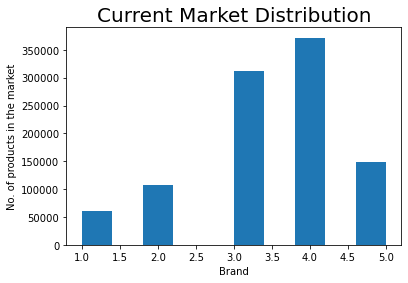

In [3]:
# Visualize the current market as a histogram
plt.hist(market)
plt.title('Current Market Distribution', size=20)
plt.xlabel('Brand')
plt.ylabel('No. of products in the market')
plt.show()

In [4]:
# Draw a small random sample
sample_size = 100 
sample = np.random.choice(market, sample_size, replace=True)

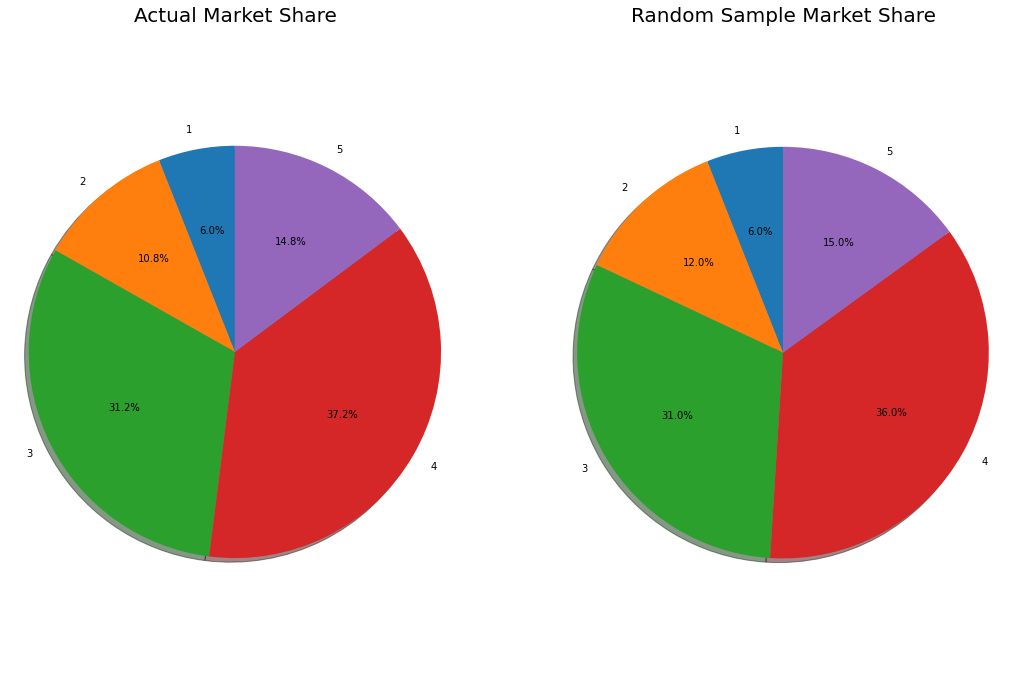

In [5]:
# Pie charts - calculated vs actual (the slices will be ordered and plotted counter-clockwise)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,12))

# Actual pie chart
labels = brands
sizes = market_share

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Actual Market Share', size=20)

# Calculated pie chart via random sampling
labels = brands
hist = np.histogram(sample, bins=len(brands))[0]
sizes = hist/sum(hist)

ax2.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Random Sample Market Share', size=20)

plt.show()

In [6]:
# Compute state of the market after one year based on the current state
def state_after_one_year(current_state):
    hist = np.histogram(current_state, bins=len(brands))[0]
    prob = hist/sum(hist) # brand attractiveness is governed by the market share
    prob_list = np.ones((sample_size,len(brands)))*(prob) 
    distribution = tfd.Categorical(probs=prob_list)
    return distribution.sample(1)

In [7]:
# Run the simulation
n_years = 10
current_state=tf.convert_to_tensor(sample, dtype='float32')

for i in range(n_years):
    current_state = state_after_one_year(current_state)

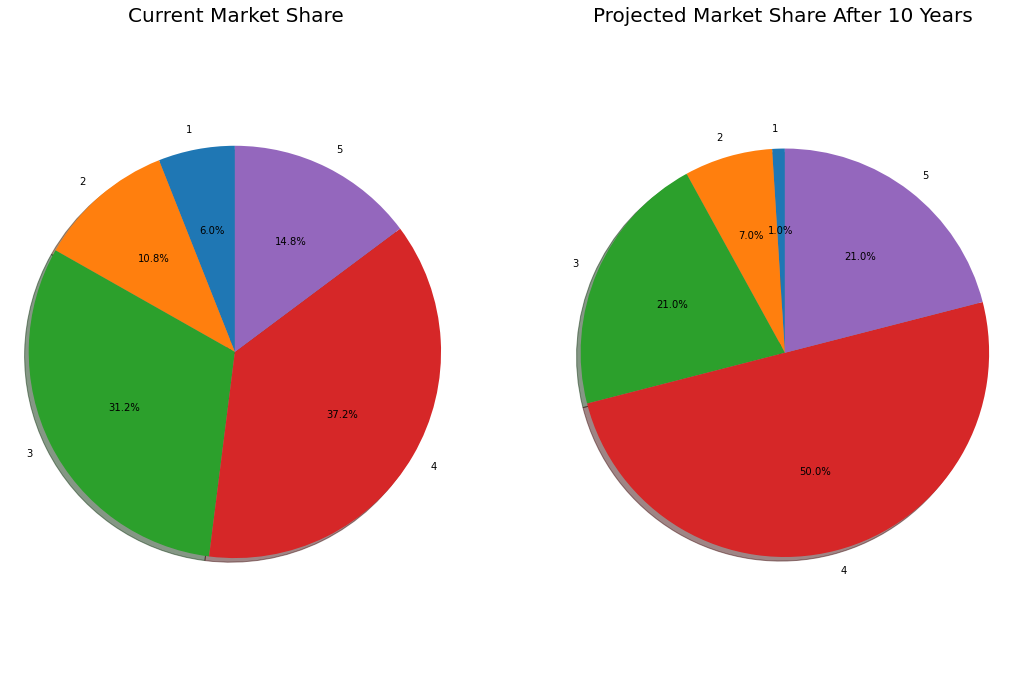

In [8]:
# Pie charts - current vs projected (the slices will be ordered and plotted counter-clockwise)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,12))

# Current pie chart
labels = brands
sizes = market_share

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Current Market Share', size=20)

# Calculated pie chart via simulation
labels = brands
hist = np.histogram(current_state, bins=len(brands))[0]
sizes = hist/sum(hist)

ax2.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=True)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title(F'Projected Market Share After {n_years} Years', size=20)

plt.show()

It is not surprising that a dominant player emerges due to the 'network effect'. For a thorough analysis one should ideally repeat the process several times. In many practical situations the actual current market share (ground truth) is unknown and a direct comparison as above cannot be made. I am grateful to the `tensorflow probability` team for providing this ergonomic toolbox. It has certainly made experimentation with probabilistic scenarios much easier.